## imports

In [2]:
!pip install psynlig
!pip install umap-learn

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from psynlig import pca_residual_variance
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## read data

In [3]:
df = pd.read_csv(r"../data/kddcup99.csv",index_col=0).reset_index(drop=True)
np.random.seed(42)
### change of decision variable classes by tagging 0 for normal and 1 for fraud ----just for kdd----
df.loc[(df.label !="normal"),"target"] = 1
df.loc[(df.label =="normal"),"target"] = 0
df = df.drop(['label'], axis=1)
feat_df = df.drop(['target'], axis=1)
label_df = df.target
df.describe()

,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target
count,4.940200e+05,4.940200e+05,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,...,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000,494020.000000
mean,3.025616e+03,8.685308e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148245,0.010212,0.000111,...,188.666052,0.753781,0.030906,0.601936,0.006684,0.176754,0.176443,0.058118,0.057412,0.803091
std,9.882191e+05,3.304003e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355343,1.798328,0.010551,...,106.040205,0.410780,0.109259,0.481309,0.042133,0.380593,0.380920,0.230590,0.230141,0.397663
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,1.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##convert qualitative features to Binary and dimensionality reduction

senario 1 : all features were standardized

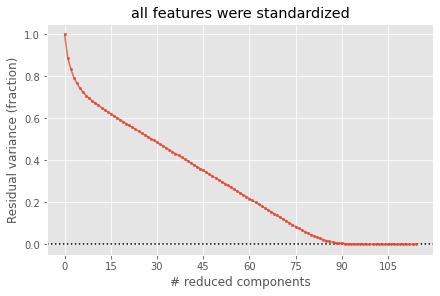

In [4]:
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df1 = feat_df.drop(obj_df.columns, axis=1)
features_df1 = pd.concat([features_df1, categorical_df], axis=1) 
col_name = features_df1.columns  
del categorical_df , obj_df
### normalze
features_df1 = pd.DataFrame(scale(features_df1))
features_df1.columns = col_name
### pca
plt.style.use('ggplot')
pca = PCA()
pca.fit_transform(features_df1)
pca_residual_variance(pca, marker='o', markersize=2, alpha=0.8)
plt.xlabel("# reduced components")
plt.title("all features were standardized")
plt.show()

senario 2 : binary features didnt standardize

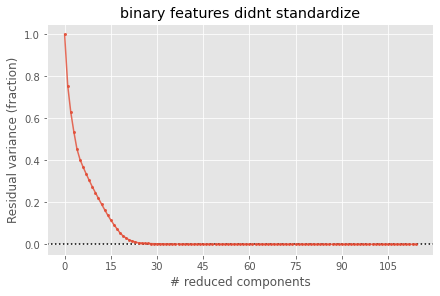

In [5]:
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df2 = feat_df.drop(obj_df.columns, axis=1)
### normalze
features_df2 = pd.DataFrame(scale(features_df2))
features_df2 = pd.concat([features_df2, categorical_df], axis=1) 
features_df2.columns = col_name  
del categorical_df , obj_df , col_name  
### pca
plt.style.use('ggplot')
pca = PCA()
pca.fit_transform(features_df2)
pca_residual_variance(pca, marker='o', markersize=2, alpha=0.8)
plt.xlabel("# reduced components")
plt.title("binary features didnt standardize")
plt.show()

## Balance check & Split data to 10 clusters

Balance check 

In [6]:
x_train, x_test, y_train, y_test = train_test_split(features_df1, label_df, train_size = 0.7, random_state = 42)  

train data

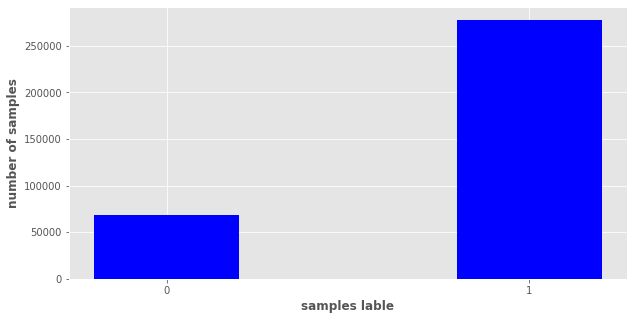

percent of normal  = 0.19699318130555732
percent of fraud  = 0.8030068186944427
total samples  = 345814


In [7]:
target = y_train.tolist()
target_counter = []
for i in range(2):
    counter = target.count(i)
    target_counter.append(counter)
fig = plt.figure(figsize = (10, 5))
numbers = ['0','1']
plt.bar(numbers, target_counter, color ='blue', width = 0.4)
plt.xlabel("samples lable", fontweight ='bold')
plt.ylabel("number of samples", fontweight ='bold')
plt.show()
print(f"percent of normal  = {target_counter[0]/len(target)}")
print(f"percent of fraud  = {target_counter[1]/len(target)}")
print(f"total samples  = {len(target)}")

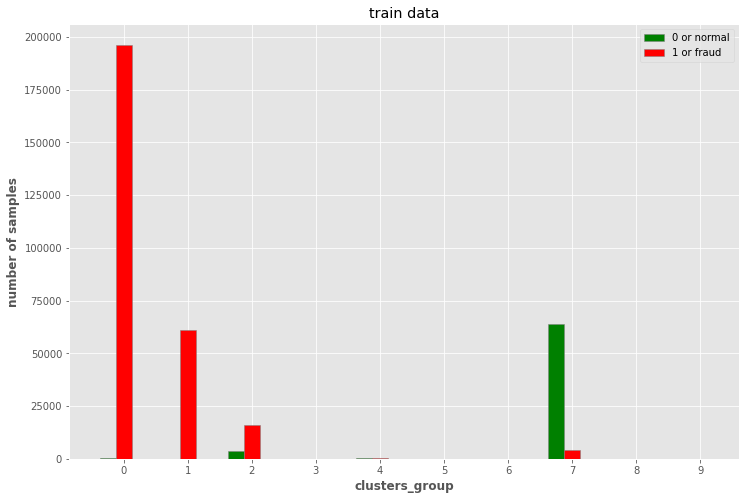

   normal  fraud 
0     251  196403
1       3   60999
2    3754   15948
3       6       0
4     272     219
5       0       1
6       0      79
7   63837    3963
8       0       1
9       0      78


In [8]:
df_train = pd.concat([x_train, y_train], axis=1)  
data = np.array(x_train).reshape(-1, x_train.shape[1])
km = KMeans(n_clusters = 10,
            init = 'k-means++',             
            max_iter = 300,
            n_init = 10,                    
            random_state = 42)

df_train['cluster_group'] = km.fit_predict(data).tolist()
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = df_train[df_train['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title("train data")
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))
train_fruad = pd.DataFrame(df_one)/sum(df_one)

test data

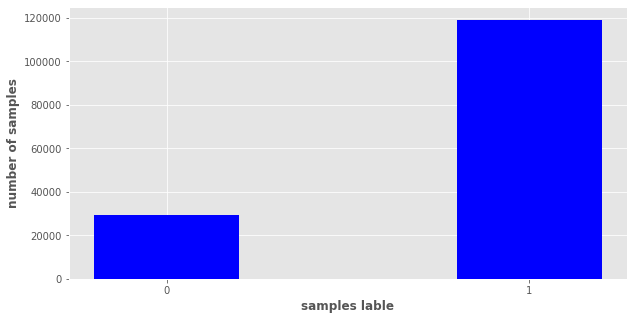

percent of normal  = 0.1967126836970163
percent of fraud  = 0.8032873163029837
total samples  = 148206


In [9]:
target = y_test.tolist()
target_counter = []
for i in range(2):
    counter = target.count(i)
    target_counter.append(counter)
fig = plt.figure(figsize = (10, 5))
numbers = ['0','1']
plt.bar(numbers, target_counter, color ='blue', width = 0.4)
plt.xlabel("samples lable", fontweight ='bold')
plt.ylabel("number of samples", fontweight ='bold')
plt.show()
print(f"percent of normal  = {target_counter[0]/len(target)}")
print(f"percent of fraud  = {target_counter[1]/len(target)}")
print(f"total samples  = {len(target)}")

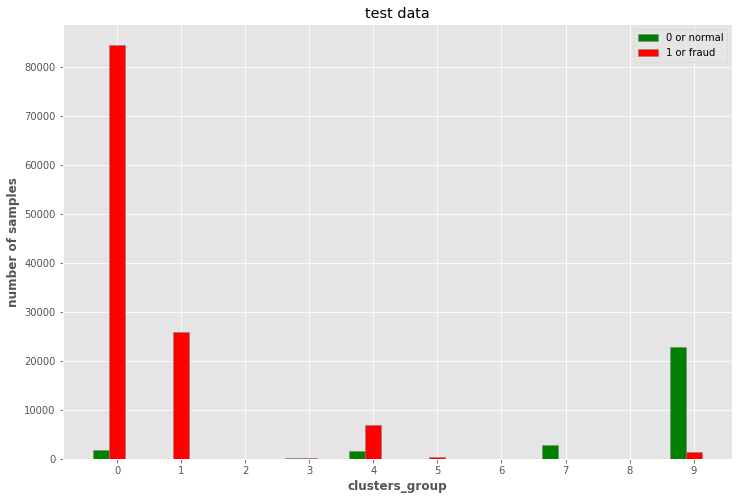

   normal  fraud 
0    1853   84493
1       2   25907
2       1       0
3      99      94
4    1641    6850
5       0     285
6       1       0
7    2810       9
8       0      32
9   22747    1382


In [10]:
df_test= pd.concat([x_test, y_test], axis=1)  
data = np.array(x_test).reshape(-1, x_test.shape[1])
km = KMeans(n_clusters = 10,
            init = 'k-means++',             
            max_iter = 300,
            n_init = 10,                    
            random_state = 42)

df_test['cluster_group'] = km.fit_predict(data).tolist()
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = df_test[df_test['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title("test data")
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))
test_fruad = pd.DataFrame(df_one)/sum(df_one)

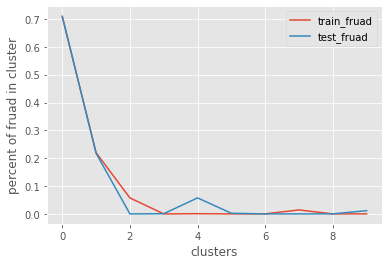

In [11]:
plt.plot(train_fruad, label = "train_fruad")
plt.plot(test_fruad, label = "test_fruad")
plt.legend()
plt.xlabel('clusters')
plt.ylabel('percent of fruad in cluster')
plt.show()

## unsupervised anomaly detection

balancing of input data based on the number of normal and fraud samples

In [12]:
features_df1['target'] = label_df
df_normal_user = features_df1[features_df1.target == 0]
df_fraud_user = features_df1[features_df1.target == 1]    
df_normal_user = df_normal_user.sample(n = 5000)
df_fraud_user = df_fraud_user.sample(n = 5000)
balanced_df = pd.concat([df_normal_user, df_fraud_user], axis=0)    
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
x_balanced = balanced_df.drop('target', axis=1)
y_balanced = balanced_df.target
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(x_balanced, y_balanced, train_size = 0.7, 
                                                    random_state = 42, stratify = y_balanced)

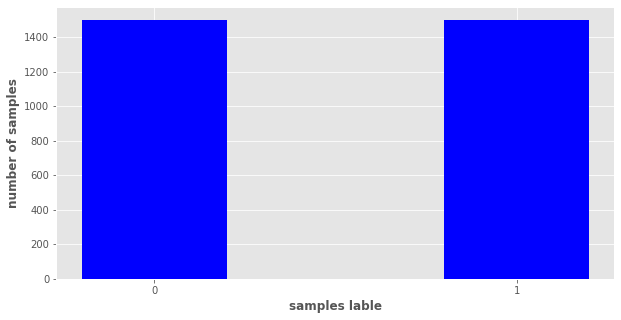

percent of normal  = 0.5
percent of fraud  = 0.5
total samples  = 3000


In [13]:
target = y_test_b.tolist()
target_counter = []
for i in range(2):
    counter = target.count(i)
    target_counter.append(counter)
fig = plt.figure(figsize = (10, 5))
numbers = ['0','1']
plt.bar(numbers, target_counter, color ='blue', width = 0.4)
plt.xlabel("samples lable", fontweight ='bold')
plt.ylabel("number of samples", fontweight ='bold')
plt.show()
print(f"percent of normal  = {target_counter[0]/len(target)}")
print(f"percent of fraud  = {target_counter[1]/len(target)}")
print(f"total samples  = {len(target)}")

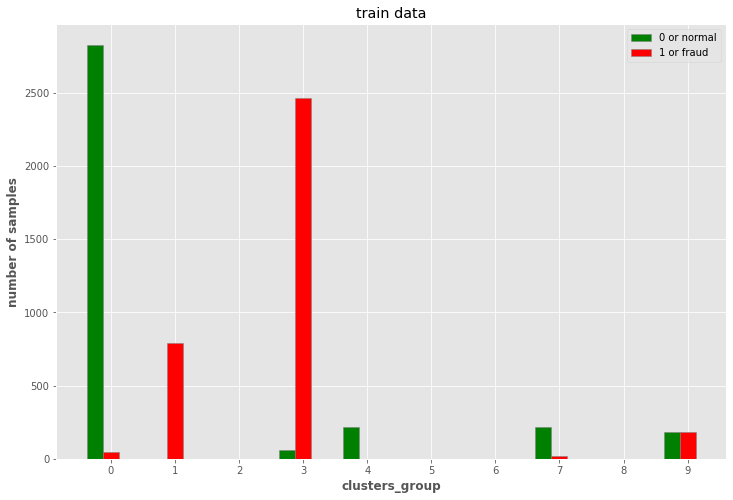

   normal  fraud 
0    2827      44
1       1     790
2       1       0
3      57    2466
4     214       0
5       1       0
6       2       0
7     214      17
8       1       0
9     182     183


In [14]:
df_train_b = pd.concat([x_train_b, y_train_b], axis=1)  
data = np.array(x_train_b).reshape(-1, x_train_b.shape[1])
km = KMeans(n_clusters = 10,
            init = 'k-means++',             
            max_iter = 300,
            n_init = 10,                    
            random_state = 42)

df_train_b['cluster_group'] = km.fit_predict(data).tolist()
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = df_train_b[df_train_b['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title("train data")
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))
train_fruad = pd.DataFrame(df_one)/sum(df_one)

test data

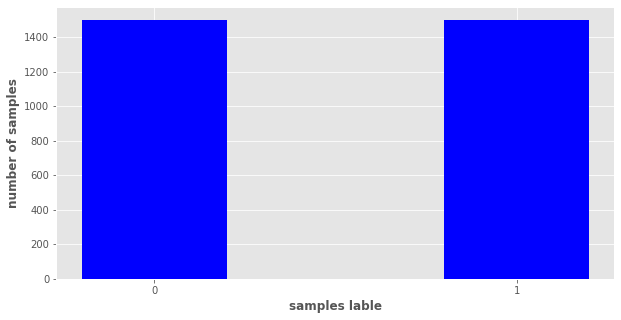

percent of normal  = 0.5
percent of fraud  = 0.5
total samples  = 3000


In [15]:
target = y_test_b.tolist()
target_counter = []
for i in range(2):
    counter = target.count(i)
    target_counter.append(counter)
fig = plt.figure(figsize = (10, 5))
numbers = ['0','1']
plt.bar(numbers, target_counter, color ='blue', width = 0.4)
plt.xlabel("samples lable", fontweight ='bold')
plt.ylabel("number of samples", fontweight ='bold')
plt.show()
print(f"percent of normal  = {target_counter[0]/len(target)}")
print(f"percent of fraud  = {target_counter[1]/len(target)}")
print(f"total samples  = {len(target)}")

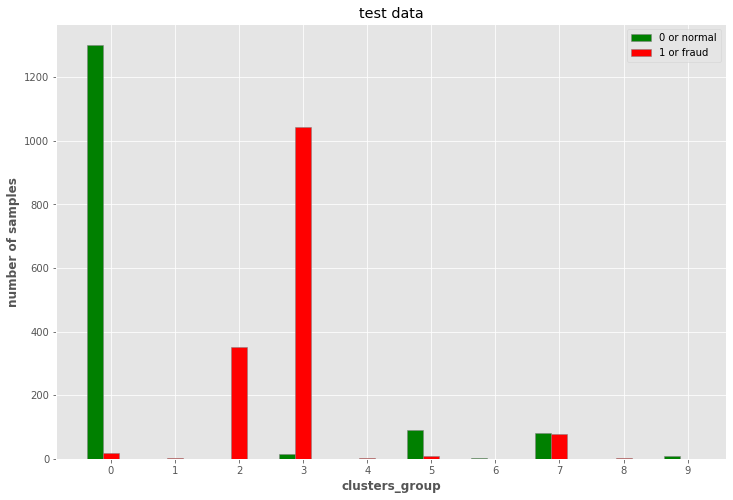

   normal  fraud 
0    1302      18
1       0       1
2       0     350
3      16    1042
4       0       1
5      90       8
6       1       0
7      81      78
8       0       2
9      10       0


In [16]:
df_test_b= pd.concat([x_test_b, y_test_b], axis=1)  
data = np.array(x_test_b).reshape(-1, x_test_b.shape[1])
km = KMeans(n_clusters = 10,
            init = 'k-means++',             
            max_iter = 300,
            n_init = 10,                    
            random_state = 42)

df_test_b['cluster_group'] = km.fit_predict(data).tolist()
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = df_test_b[df_test_b['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title("test data")
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))
test_fruad = pd.DataFrame(df_one)/sum(df_one)

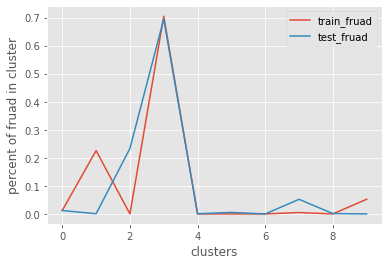

In [17]:
plt.plot(train_fruad, label = "train_fruad")
plt.plot(test_fruad, label = "test_fruad")
plt.legend()
plt.xlabel('clusters')
plt.ylabel('percent of fruad in cluster')
plt.show()

One-Class Support Vector Machines 

In [18]:
np.random.seed(31)
svm_model = svm.OneClassSVM()
svm_model.fit(x_train_b)
svm_pred = svm_model.predict(x_train_b)
svm_pred = pd.Series(svm_pred).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y_train_b, svm_pred))
print('*********confusion_matrix*********')
print(svm_conf_mat)
index = []
test_score = []
valid_score = []   
index.append("recall_score")
test_score.append(recall_score(y_train_b, svm_pred)) 
index.append("precision_score")
test_score.append(precision_score(y_train_b, svm_pred))
index.append("f1_score")
test_score.append(f1_score(y_train_b, svm_pred))  
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_train_b, svm_pred))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_train_b, svm_pred))
### summary scores in dataframe 
print('*********scores *********')
print(pd.DataFrame({"index":index ,"score" :test_score }))

*********confusion_matrix*********
      0     1
0  1677  1823
1   499  3001
*********scores *********
                 index     score
0         recall_score  0.857429
1      precision_score  0.622098
2             f1_score  0.721048
3    cohen_kappa_score  0.336571
4  roc_auccuracy_score  0.668286


error analusis for svm model outputs

train_data

In [19]:
y_df_train = pd.DataFrame(y_train_b).reset_index(drop = True)
y_df_train['pred_label'] = svm_pred
clusters = df_train_b.cluster_group.reset_index()
y_df_train['cluster_group'] = clusters.cluster_group


In [20]:
error_df = y_df_train[y_df_train.target != y_df_train.pred_label]

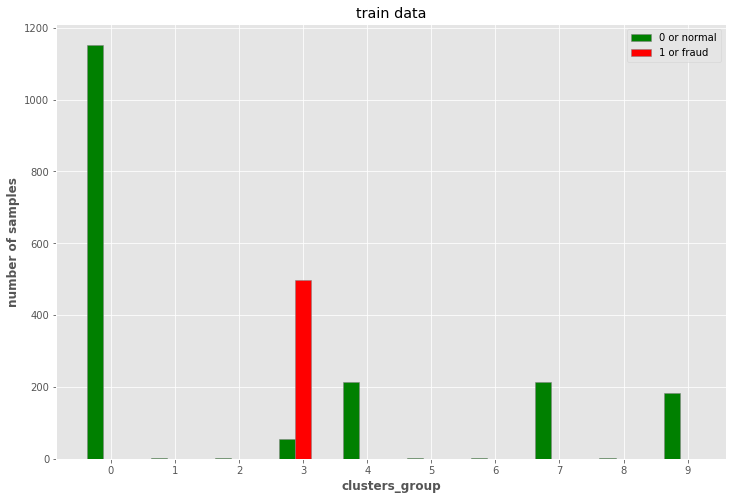

   normal  fraud 
0    1153       0
1       1       0
2       1       0
3      54     499
4     214       0
5       1       0
6       2       0
7     214       0
8       1       0
9     182       0


In [27]:
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = error_df[error_df['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title("train data")
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))
train_fruad2 = pd.DataFrame(df_one)/sum(df_one)

test data

In [28]:
svm_pred_test = svm_model.predict(x_test_b)

In [29]:
y_df_test = pd.DataFrame(y_test_b).reset_index(drop = True)
y_df_test['pred_label'] = svm_pred_test
clusters = df_test_b.cluster_group.reset_index()
y_df_test['cluster_group'] = clusters.cluster_group

In [30]:
error_df_test = y_df_test[y_df_test.target != y_df_test.pred_label]

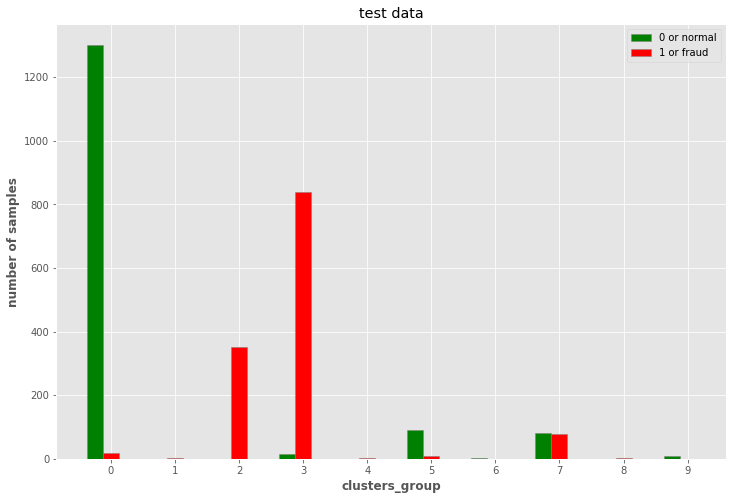

   normal  fraud 
0    1302      18
1       0       1
2       0     350
3      16     840
4       0       1
5      90       8
6       1       0
7      81      78
8       0       2
9      10       0


In [31]:
df_zero = []
df_one = []
nember_of_cluster = 10
for i in range(nember_of_cluster):
    df_1 = error_df_test[error_df_test['cluster_group']==i]
    df_1_list = df_1['target'].tolist()
    df_zero.append(df_1_list.count(0))
    df_one.append(df_1_list.count(1))

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
br1 = np.arange(len(df_zero))
br2 = [x + barWidth for x in br1]
# Make the plot
plt.bar(br1, df_zero, color ='g', width = barWidth,
        edgecolor ='grey', label ='0 or normal')
plt.bar(br2, df_one, color ='r', width = barWidth,
        edgecolor ='grey', label ='1 or fraud')
lst = [i for i in range(0,10)] 
plt.xlabel('clusters_group', fontweight ='bold')
plt.ylabel('number of samples', fontweight ='bold')
plt.xticks([r + barWidth for r in range(len(df_zero))],lst) 
plt.legend()
plt.title("test data")
plt.show()
print(pd.DataFrame({'normal' : df_zero, 'fraud ' : df_one}))
test_fruad2 = pd.DataFrame(df_one)/sum(df_one)

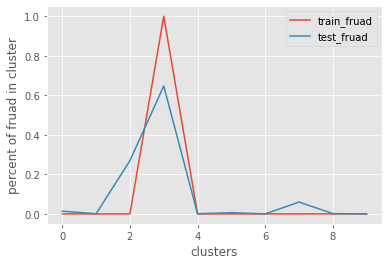

In [32]:
plt.plot(train_fruad2, label = "train_fruad")
plt.plot(test_fruad2, label = "test_fruad")
plt.legend()
plt.xlabel('clusters')
plt.ylabel('percent of fruad in cluster')
plt.show()